In [1]:
# basics
import pandas as pd
import numpy as np
import collections

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# tools
import scipy
import math
import random
import sklearn
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')

# # handle from here
finalbooks = pd.read_csv('finalbooks.csv')
ratings = pd.read_csv('finalratings.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NITEESHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
## NDGC & RMSE

def dcg_k(r, k):
    """ Discounted Cumulative Gain (DGC)  
    Args:
        r: True Ratings in Predicted Rank Order (1st element is top recommendation)
        k: Number of results to consider
    Returns:
        DCG
    """
  
    r = np.asfarray(r)[:k]
    return np.sum(2**r / np.log2(np.arange(2, r.size + 2)))      



def ndcg_k(r, k):
    """Normalized Discounted Cumulative Gain (NDCG)
    Args:
        r: True Ratings in Predicted Rank Order (1st element is top recommendation)
        k: Number of results to consider
    Returns:
        NDCG
    """
    dcg_max = dcg_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_k(r, k) / dcg_max

def mean_ndcg(rs):
    """Mean NDCG for all users
    Args:
        rs: Iterator / For each user: True Ratings in Predicted Rank Order
    Returns:
        Mean NDCG
    """
    return np.mean([ndcg_k(r, len(r)) for r in rs])

def rmse(y,h):
    """RMSE
    Args:
        y: real y
        h: predicted y
    Returns:
        RMSE
    """
    a = y-h

    return np.sqrt(sum(a**2)/len(a))

In [3]:
## DEFINING THE TAIL
tailcomp = ratings.groupby(by= 'newbookid', as_index=False).agg({'rating':pd.Series.count}).sort_values(by = 'rating', ascending = False)
tot = sum(tailcomp['rating'])
tailcomp['popshare']= [x/tot for x in tailcomp['rating']]
tailcomp['popshare']= tailcomp['popshare'].cumsum()
tailcomp['category']= ['Head' if x<0.95 else "Tail" for x in tailcomp['popshare']]

tail = tailcomp.loc[tailcomp.popshare >= 0.95]
tail

,newbookid,rating,popshare,category
5458,6115,35,0.950003,Tail
4776,5341,35,0.950036,Tail
4154,4641,35,0.950069,Tail
5735,6433,35,0.950103,Tail
6180,6945,35,0.950136,Tail
...,...,...,...,...
1643,1775,1,0.999996,Tail
6510,7309,1,0.999997,Tail
4748,5310,1,0.999998,Tail
1688,1824,1,0.999999,Tail


In [4]:
def get_words(message):
    """Get the normalized list of words from a message string.

    This function should split a message into words, normalize them, and return
    the resulting list. For splitting, you should split on spaces. For normalization,
    you should convert everything to lowercase.

    Args:
        message: A string containing an SMS message

    Returns:
       The list of normalized words from the message.
    """


    words = message
    words = words.split(" ")
    words = [x.lower() for x in words]

    return words



def create_dictionary(messages):
    """Create a dictionary mapping words to integer indices.

    Args:
        messages: A list of strings containing SMS messages

    Returns:
        A python dict mapping words to integers.
    """

    word_counts = collections.defaultdict(int)

    for message in messages:
        for word in set(get_words(message)):
            word_counts[word] += 1

    resulting_dictionary = {}

    for word, count in word_counts.items():
        if count >= 10 and word not in stopwords.words('english') and len(word) > 1:
            next_index = len(resulting_dictionary)
            resulting_dictionary[word] = next_index

    return resulting_dictionary


def transform_text(messages, word_dictionary):
    """Transform a list of text messages into a numpy array for further processing.

    Args:
        messages: A list of strings where each string is an SMS message.
        word_dictionary: A python dict mapping words to integers.

    Returns:
        A numpy array marking the words present in each message.
        Where the component (i,j) is the number of occurrences of the
        j-th vocabulary word in the i-th message.
    """

    A = np.zeros((len(messages), len(word_dictionary)))

    for i, message in enumerate(messages):
        for word in get_words(message):
            if word in word_dictionary:
                A[i, word_dictionary[word]] += 1

    return A

In [5]:
finalbooks['snippet'] = finalbooks['snippet'].fillna(finalbooks['title'])
finalbooks['snippet'] = finalbooks['snippet'].str.replace(r'[^\w\s]',"")
finalbooks['snippet'] = finalbooks['snippet'].str.replace('-',"")
finalbooks['tag_cloud'] = finalbooks['tag_cloud'].str.replace('-'," ")
finalbooks['snippet'] = finalbooks['snippet'].fillna(finalbooks['tag_cloud'])
finalbooks['words'] = finalbooks['snippet'] +" "+finalbooks['tag_cloud']+" "+finalbooks['first_author']
#finalbooks['words'] = finalbooks['snippet'] +" "+finalbooks['first_author']
dico = create_dictionary(finalbooks['words'])
dico

{'collins': 0,
 'region': 1,
 'books|the': 2,
 'certain': 3,
 'time': 4,
 'games': 5,
 'grace': 6,
 '12': 7,
 'rebellion': 8,
 'destruction': 9,
 'fiction|books': 10,
 'means': 11,
 'forced': 12,
 'bigger': 13,
 'north': 14,
 'fi': 15,
 'nature': 16,
 'trained': 17,
 'system': 18,
 'country': 19,
 'history': 20,
 'selected': 21,
 'suzanne': 22,
 'sister': 23,
 'stars|i': 24,
 'death': 25,
 'losing': 26,
 'second': 27,
 'america': 28,
 '2010|my': 29,
 'reading|young': 30,
 'led': 31,
 'creation': 32,
 'fight': 33,
 'female': 34,
 'ages': 35,
 'favorites|currently': 36,
 'postapocalyptic': 37,
 'district': 38,
 'series|teen': 39,
 'fantasy|ya': 40,
 'make': 41,
 'whole': 42,
 'books|scifi': 43,
 'survivor': 44,
 'boy': 45,
 'star': 46,
 'books|own': 47,
 'survival': 48,
 'leaving': 49,
 'winning': 50,
 'event': 51,
 'sees': 52,
 'early': 53,
 '18': 54,
 'place': 55,
 'fiction|2012': 56,
 'sentence': 57,
 'nation': 58,
 'young': 59,
 'close': 60,
 'power': 61,
 'claim': 62,
 'hunger': 63,

In [7]:
len(dico)

11200

In [8]:
A = transform_text(finalbooks['words'], dico)

In [9]:
np.size(A, 0)

8000

In [10]:
np.sum(A, axis=1).min()

6.0

In [11]:
A1 = np.sum((A>0), axis= 0)

IDF = np.log(np.size(A, 0)/A1)
IDF
len(IDF)

11200

In [12]:
TF = A / (np.sum(A, axis=1, keepdims=True))
np.shape(TF)

(8000, 11200)

In [13]:
TFiDF= TF*IDF
np.shape(TFiDF)

(8000, 11200)

In [14]:
#ids = np.argsort(TFiDF.mean(axis=1))[:5]
#reverse_dictionary = {i: word for word, i in dico.items()}
#[reverse_dictionary[i] for i in ids]

In [15]:
TFiDF = TFiDF / np.sqrt((np.sum(TFiDF**2, axis = 1, keepdims=True)+0.01))

In [16]:
SimC = np.dot(TFiDF, TFiDF.T)

In [17]:
SimC

array([[0.96164977, 0.02911102, 0.00524494, ..., 0.00446057, 0.00878316,
        0.03299201],
       [0.02911102, 0.98739694, 0.00946556, ..., 0.        , 0.00676241,
        0.00110098],
       [0.00524494, 0.00946556, 0.97151082, ..., 0.00384577, 0.00215187,
        0.00315417],
       ...,
       [0.00446057, 0.        , 0.00384577, ..., 0.98239163, 0.        ,
        0.00138774],
       [0.00878316, 0.00676241, 0.00215187, ..., 0.        , 0.96382747,
        0.0092722 ],
       [0.03299201, 0.00110098, 0.00315417, ..., 0.00138774, 0.0092722 ,
        0.96017134]])

In [18]:
np.sum(SimC, axis = 1).max()

210.53071341774012

In [19]:
np.fill_diagonal(SimC, 1)

In [20]:
SimC

array([[1.        , 0.02911102, 0.00524494, ..., 0.00446057, 0.00878316,
        0.03299201],
       [0.02911102, 1.        , 0.00946556, ..., 0.        , 0.00676241,
        0.00110098],
       [0.00524494, 0.00946556, 1.        , ..., 0.00384577, 0.00215187,
        0.00315417],
       ...,
       [0.00446057, 0.        , 0.00384577, ..., 1.        , 0.        ,
        0.00138774],
       [0.00878316, 0.00676241, 0.00215187, ..., 0.        , 1.        ,
        0.0092722 ],
       [0.03299201, 0.00110098, 0.00315417, ..., 0.00138774, 0.0092722 ,
        1.        ]])

In [21]:
BookSim =pd.DataFrame(SimC, columns=finalbooks.title, index=finalbooks.title)

In [22]:
#np.argsort(SimC[53, :])[-5:]
finalbooks.title[np.argsort(SimC[15, :])[-6:]]
#Sim20 = pd.DataFrame(Sim20, columns=finalbooks.title[101:200], index=finalbooks.title[50:60])

3481                 The Exiled Queen (Seven Realms, #2)
940                                            The Hours
5330               The Readers of Broken Wheel Recommend
3607                          The Universe in a Nutshell
4731                            Min kamp 1 (Min kamp #1)
15      The Girl with the Dragon Tattoo (Millennium, #1)
Name: title, dtype: object

In [23]:
#SimC[15, [15, 2252, 6977, 4642, 2796, 1700 ]]

In [24]:
finalbooks [finalbooks.newbookid.isin(np.argsort(SimC[15, :])[-6:]+1)]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_5,image_url,small_image_url,newbookid,tag_cloud,firstgenre,snippet,pages,first_author,words
15,16,2429135,2429135,1708725,274,307269752,9.780307e+12,"Stieg Larsson, Reg Keeland",2005.0,Män som hatar kvinnor,...,836050,https://images.gr-assets.com/books/1327868566m...,https://images.gr-assets.com/books/1327868566s...,16,to read|currently reading|fiction|mystery|favo...,to-read,Mikael Blomkvist ekonomireporter döms till fän...,566 pages,Stieg Larsson,Mikael Blomkvist ekonomireporter döms till fän...
940,941,11899,11899,2245431,138,312305060,9.780312e+12,Michael Cunningham,1998.0,The Hours,...,35489,https://images.gr-assets.com/books/1479663379m...,https://images.gr-assets.com/books/1479663379s...,941,fiction|currently reading|historical fiction|p...,fiction,Una mañana de 1923 en un suburbio de Londres V...,230 pages,Michael Cunningham,Una mañana de 1923 en un suburbio de Londres V...
3481,3563,7801229,7801229,9842102,22,1423118243,9.781423e+12,Cinda Williams Chima,2010.0,The Exiled Queen,...,18077,https://images.gr-assets.com/books/1285276245m...,https://images.gr-assets.com/books/1285276245s...,3482,to read|fantasy|favorites|young adult|currentl...,to-read,Haunted by the loss of his mother and sister H...,586 pages,Cinda Williams Chima,Haunted by the loss of his mother and sister H...
3607,3696,2095,2095,1978857,80,055380202X,9.780554e+12,Stephen Hawking,2001.0,The Universe in a Nutshell,...,9920,https://images.gr-assets.com/books/1159814395m...,https://images.gr-assets.com/books/1159814395s...,3608,to read|physics|science|non fiction|nonfiction...,to-read,Stephen Hawking uno de los pensadores más infl...,216 pages,Stephen Hawking,Stephen Hawking uno de los pensadores más infl...
4731,4969,7147831,7147831,7412679,93,NaN,9.788253e+12,Karl Ove Knausgård,2009.0,Min kamp 1,...,7729,https://images.gr-assets.com/books/1262695721m...,https://images.gr-assets.com/books/1262695721s...,4732,to read|non fiction|biography|norwegian|contem...,to-read,Romanen åpner med en svimlende beskrivelse av ...,435 pages,Karl Ove Knausgård,Romanen åpner med en svimlende beskrivelse av ...
5330,5687,25573977,25573977,25758335,63,149262344X,9.781493e+12,"Katarina Bivald, Alice Menzies",2013.0,Läsarna i Broken Wheel rekommenderar,...,3588,https://images.gr-assets.com/books/1452107441m...,https://images.gr-assets.com/books/1452107441s...,5331,to read|fiction|currently reading|books about ...,to-read,Allting börjar med en brevväxling mellan två h...,396 pages,Katarina Bivald,Allting börjar med en brevväxling mellan två h...


<AxesSubplot:xlabel='title', ylabel='title'>

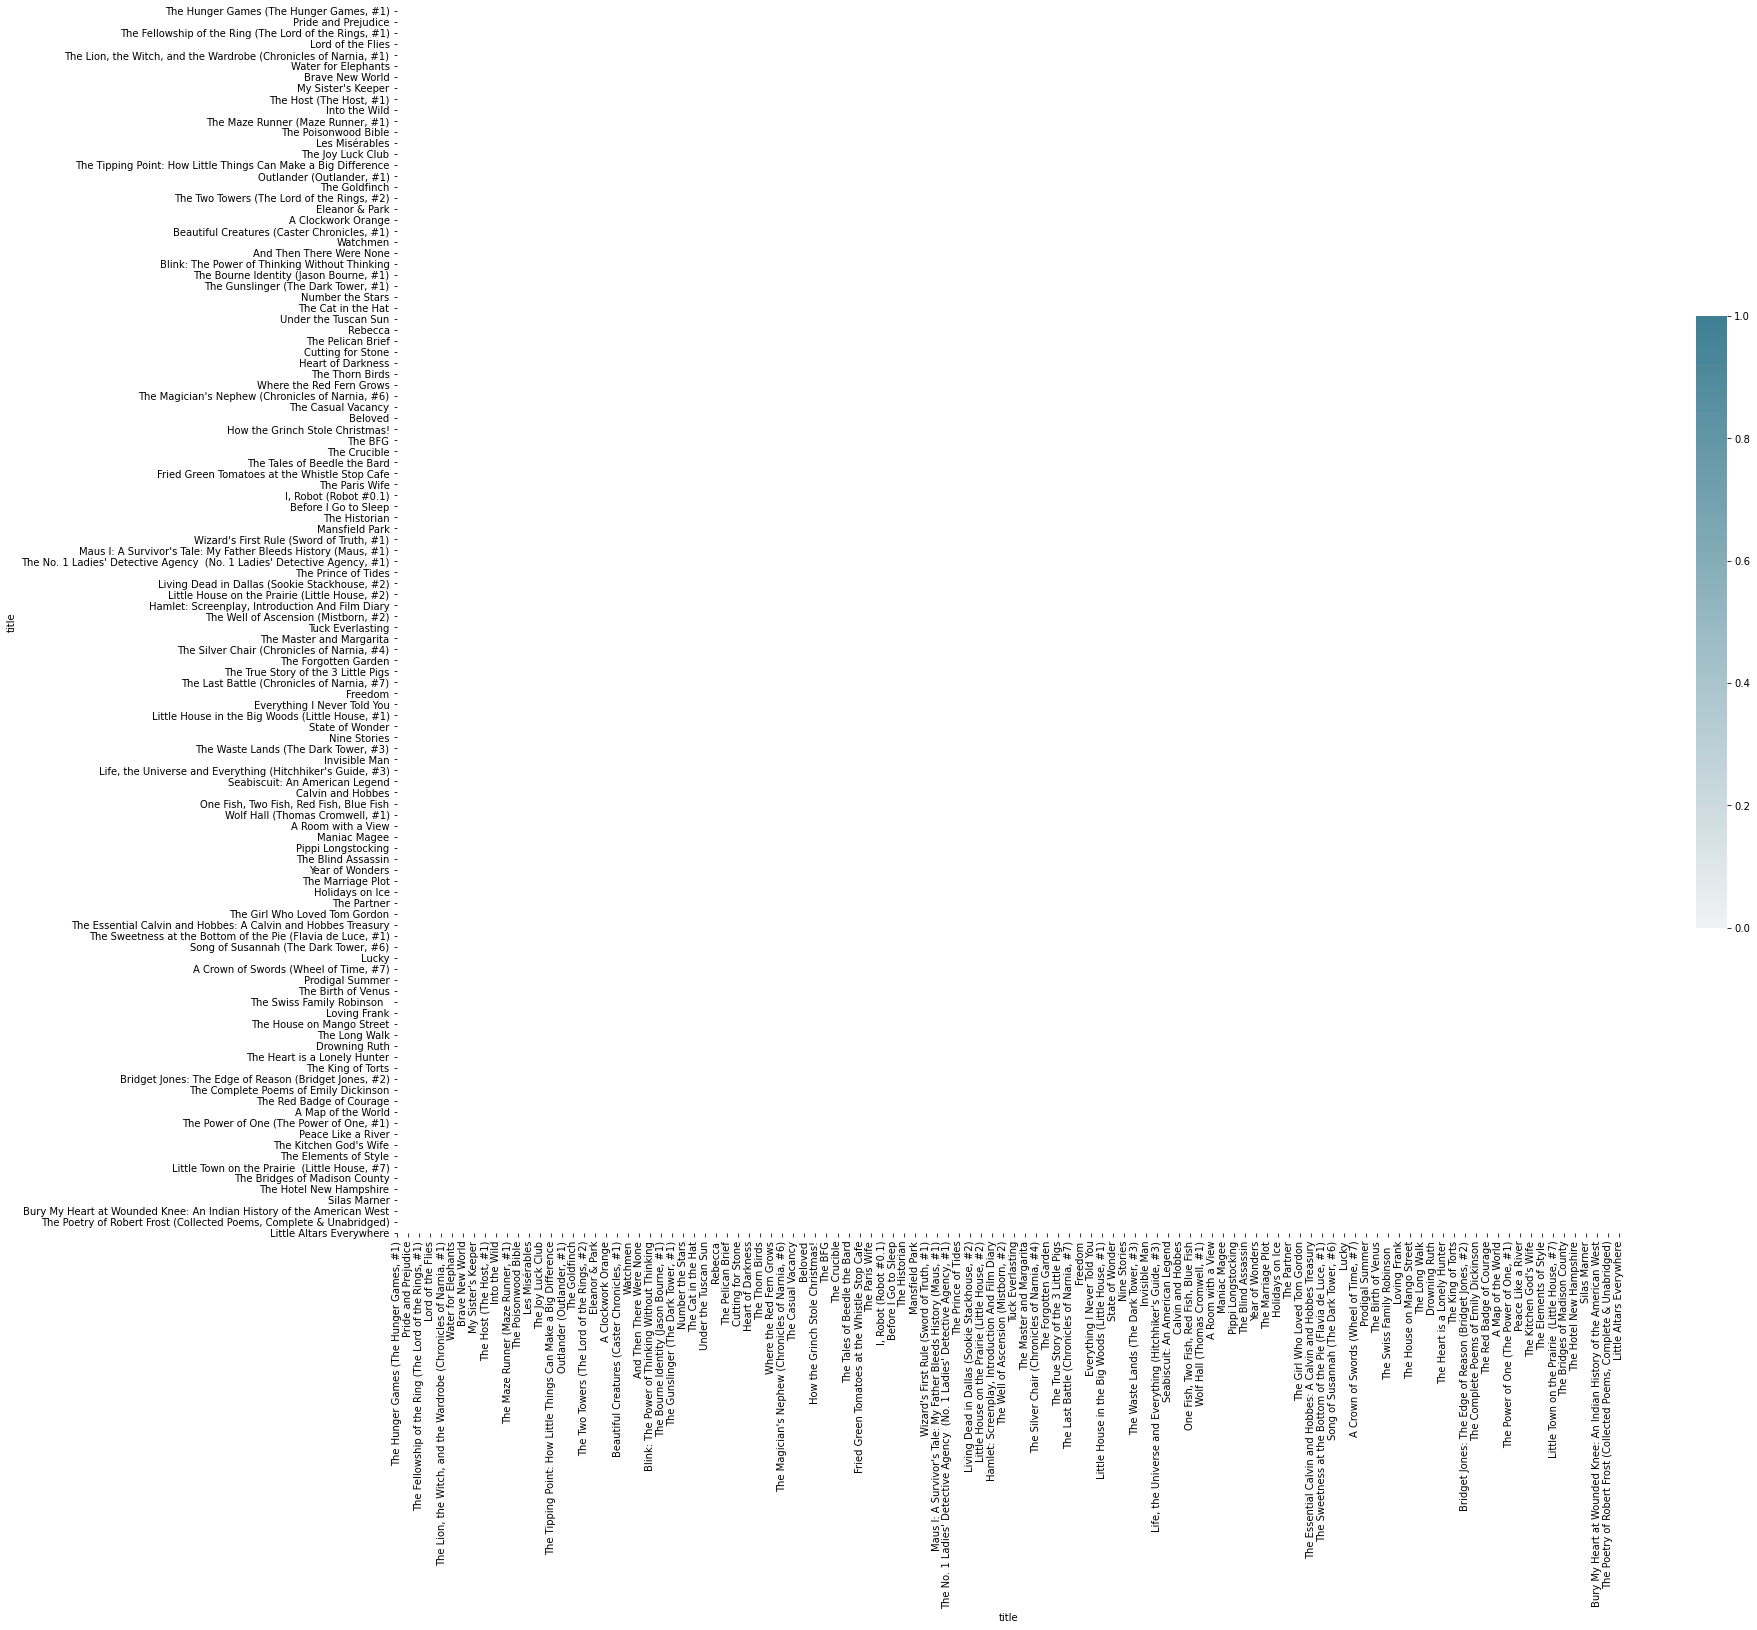

In [39]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(27.5, 22.5))

# Generate a custom diverging colormap followed by the correlation heatmap
cmap =sns.diverging_palette(20, 220, n=20000)

sns.heatmap(BookSim, cmap=cmap,center = 0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [25]:
allpreds = []
train = train.sort_values(by=['newbookid'])
for i in range(15000):
  bi = train.newbookid[train.newuser_id == i+1]-1
  Simi = SimC[:, bi]
  ri = np.array(train[train.newuser_id == i+1].sort_values(by=['newbookid']).rating)
  predi = finalbooks.filter(['newbookid'])
  predi['pred'] = np.sum(Simi*ri, axis=1)/(np.sum(Simi, axis=1)+0.01)
  predi['newuser_id'] = i+1
  allpreds.append(predi)
  if (i+1)%1000 == 0: print("done: ", i+1)

done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000


In [26]:
predictions = np.concatenate(allpreds, axis=0 )

In [27]:
final = pd.DataFrame(predictions, columns=['newbookid', 'pred', 'newuser_id'])

In [28]:
train['conc']=train['newuser_id'].map(str)+train['newbookid'].map(str)
final['conc']=final['newuser_id'].map(str)+final['newbookid'].map(str)
finalfin = final[~final.conc.isin(train.conc)]
finalfin.describe()

,newbookid,pred,newuser_id
count,1.500000e+07,1.500000e+07,1.500000e+07
mean,5.005000e+02,2.552488e-01,7.500500e+03
std,2.886750e+02,9.639768e-01,4.330127e+03
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,2.507500e+02,0.000000e+00,3.750750e+03
50%,5.005000e+02,0.000000e+00,7.500500e+03
75%,7.502500e+02,0.000000e+00,1.125025e+04
max,1.000000e+03,4.994460e+00,1.500000e+04


In [30]:
finalrank = test.merge(final,on = ['newbookid', 'newuser_id'])
finalrank = finalrank.sort_values(by=['newuser_id', 'pred'], ascending=False)
finalrank.head(5)

,rating,newbookid,newuser_id,pred,conc
17640,5,569,1000,4.993019,1000.0569.0
21917,5,863,1000,4.992650,1000.0863.0
13763,5,461,1000,4.992584,1000.0461.0
12700,5,898,1000,4.991977,1000.0898.0
14762,5,805,1000,4.991738,1000.0805.0


In [31]:
finallist = []
for i in range(15000):
    a = finalrank.loc[finalrank.newuser_id == i+1]['rating'].tolist()
    finallist.append(a)
    if (i+1)%1000 == 0: print("done: ", i+1)

done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000


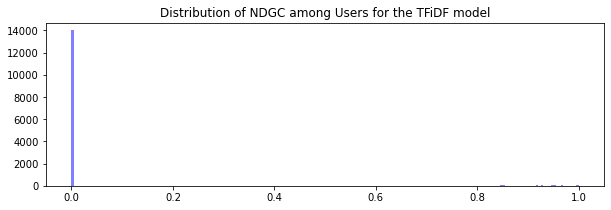

In [32]:
b = np.array([ndcg_k(r, len(r)) for r in finallist])


facet, axes = plt.subplots(1, 1, figsize=(10, 3))
n, bins, patches = plt.hist(b, 200, facecolor='blue', alpha=0.5) #, log = True)   
plt.title('Distribution of NDGC among Users for the TFiDF model')
plt.show()

# [ndcg_k(r, len(r)) for r in poplista]

In [33]:
d = b[b == 1]
sum(d)/15000

0.0019333333333333333

In [34]:
print('(1) TF-iDF Model RMSE: ', np.round(rmse(finalrank['pred'],finalrank['rating']), decimals=3))
print('(2) TF-iDF Model NDCG: ', np.round(mean_ndcg(finallist), decimals=3))
print("(2) Median NDCG: ", np.round(np.median(b), decimals=3))
print("(2) Share of NDCG =1 among Users: ", np.round(sum(d)/15000, decimals=3))

(1) TF-iDF Model RMSE:  0.895
(2) TF-iDF Model NDCG:  0.059
(2) Median NDCG:  0.0
(2) Share of NDCG =1 among Users:  0.002


In [35]:
top10 = finalfin.sort_values('pred',ascending = False).groupby('newuser_id').head(10)
top50 = finalfin.sort_values('pred',ascending = False).groupby('newuser_id').head(50)

print('(3) TF-iDF Model Div10 Score: ',np.round(sum(np.in1d(top10.newbookid, tail.newbookid))/len(top10), decimals=3))
print('(3) TF-iDF Model Div50 Score: ',np.round(sum(np.in1d(top50.newbookid, tail.newbookid))/len(top50), decimals=3))

(3) TF-iDF Model Div10 Score:  0.16
(3) TF-iDF Model Div50 Score:  0.143


In [36]:
finalranktrain = train.merge(final,on = ['newbookid', 'newuser_id'])
finalranktrain = finalranktrain.sort_values(by=['newuser_id', 'pred'], ascending=False)

In [37]:
finallisttrain = []
for i in range(15000):
    a = finalranktrain.loc[finalranktrain.newuser_id == i+1]['rating'].tolist()
    finallisttrain.append(a)
    if (i+1)%1000 == 0: print("done: ", i+1)

done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000


In [38]:
print('(1) TF-iDF Train Model RMSE: ', np.round(rmse(finalranktrain['pred'],finalranktrain['rating']), decimals=3))
print('(2) TF-iDF Train Model NDCG: ', np.round(mean_ndcg(finallisttrain), decimals=3))

(1) TF-iDF Train Model RMSE:  0.7
(2) TF-iDF Train Model NDCG:  0.066
